In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,roc_curve

%matplotlib inline
plt.style.use('seaborn-white')

In [3]:
dataset="bank-additional-full.csv"
bankdata=pd.read_csv(dataset, delimiter=";")
bankdata["response"] = bankdata.y.map({'no':0, 'yes':1})

bankdata.drop(["y"],axis=1, inplace=True)

In [4]:
dict_values=dict(bankdata["response"].value_counts())
print(dict_values)
print(dict_values[1]/(dict_values[0]+dict_values[1])) #data is imbalanced
#Research on imbalanced classes often considers imbalanced to mean a minority class of 10% to 20%


{0: 36548, 1: 4640}
0.11265417111780131


In [5]:
bankdata.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [6]:
cat_bankdata = bankdata.select_dtypes(include=['object']).copy() #dataframe of columns with object type columns
int_float_bankdata= bankdata.select_dtypes(include=['int64','float64']).copy() #dataframe of columns with int64,float64 type columns
cat_bankdata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 10 columns):
job            41188 non-null object
marital        41188 non-null object
education      41188 non-null object
default        41188 non-null object
housing        41188 non-null object
loan           41188 non-null object
contact        41188 non-null object
month          41188 non-null object
day_of_week    41188 non-null object
poutcome       41188 non-null object
dtypes: object(10)
memory usage: 3.1+ MB


In [7]:
#converting categories into numeric types(numeric encoding)

cat_column=cat_bankdata.columns.tolist()

for i in cat_column:
    cat_bankdata[i] = cat_bankdata[i].astype('category')
    cat_bankdata[i] = cat_bankdata[i].cat.codes
    
cat_bankdata.head() 

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,3,1,0,0,0,0,1,6,1,1
1,7,1,3,1,0,0,1,6,1,1
2,7,1,3,0,2,0,1,6,1,1
3,0,1,1,0,0,0,1,6,1,1
4,7,1,3,0,0,2,1,6,1,1


In [8]:
from sklearn.feature_selection import VarianceThreshold

var_bankdata=pd.concat([int_float_bankdata,cat_bankdata],axis=1)
variance_filter = VarianceThreshold(threshold=0.1)
variance_filter.fit(var_bankdata)  

#Now to get all the features that are NOT CONSTANT, we can use the get_support() method of the filter that we created
#the number of constant features with the help of the following script:
constant_columns = [column for column in var_bankdata.columns  
                    if column not in var_bankdata.columns[variance_filter.get_support()]]
bankdata_filtered=var_bankdata[var_bankdata.columns[variance_filter.get_support()]]

bankdata_filtered.info()  #not include "response"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
job               41188 non-null int8
marital           41188 non-null int8
education         41188 non-null int8
default           41188 non-null int8
housing           41188 non-null int8
loan              41188 non-null int8
contact           41188 non-null int8
month             41188 non-null int8
day_of_week       41188 non-null int8
poutcome          41188 non-null int8
dtypes: float64(5), int64(5), int8(10)
memory usage: 3.5 MB


In [11]:
print(constant_columns)

['response']


In [12]:
#print(no_relation_column)  #returns ['housing', 'loan']
cat_bankdata = bankdata.select_dtypes(include=['object']).copy() #reassigning cat_bankdata for one-hot-encoding
#cat_bankdata.drop(columns=list(no_relation_list), axis=1, inplace=True)  
cat_bankdata.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


IMPORTANT NOTE ABOUT ONE-HOT-ENCODING
When we are using one-hot encoding datasets, we are introducing multicollinearity, which can be a problem for certain methods,like matrix inversion. If there is a high correlation betweeen features, matrices are
computationally difficult to invert, which results in numerically unstable estimates.
In order to reduce the correlation among variables, simply remove one feature
column from the one-hot encoded array. Notice that we do not lose any important
information by removing a feature column. For example, if we remove the
column job_admin, the feature information is still preserved since if we observe
job_services=0,  job_housemaid=0 etc, it implies that the observation must be admin.
So,when we use the get_dummies function, we can drop the first column by passing a True
argument to the drop_first parameter.



In [13]:
#creating dummy variables from categorical features (One-Hot encoding)>> this has the benefit of not weighting a value improperly.
#sklearn has "LabelBinarizer" class for one- hot encoding
cat_bankdata_dummy = cat_bankdata.copy()
cat_column_list=cat_bankdata.columns.tolist()

cat_bankdata_dummy = pd.get_dummies(cat_bankdata_dummy, columns=cat_column_list, prefix = cat_column_list,drop_first=True)


#print(cat_bankdata_dummy.info())

In [15]:
int_float_bankdata.drop(columns=["response"])

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0
5,45,198,1,999,0,1.1,93.994,-36.4,4.857,5191.0
6,59,139,1,999,0,1.1,93.994,-36.4,4.857,5191.0
7,41,217,1,999,0,1.1,93.994,-36.4,4.857,5191.0
8,24,380,1,999,0,1.1,93.994,-36.4,4.857,5191.0
9,25,50,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [23]:
#Concatenating back with the remaining columns, which can be done via pandas' .concat() method. 
#The axis argument is set to 1 as you want to merge on columns.

resulting_bankdata = pd.concat([cat_bankdata_dummy, int_float_bankdata], axis=1)
resulting_feature_set=resulting_bankdata.drop(["response"],axis=1) #response variable excluded
#len(resulting_feature_set.columns.values)


In [24]:
int_float_bankdata.shape, cat_bankdata_dummy.shape, resulting_bankdata.shape, resulting_feature_set.shape

((41188, 11), (41188, 43), (41188, 54), (41188, 53))

In [25]:
#Removing Correlated Features
#Two or more than two features are correlated if they are close to each other in the linear space.
#Correlation between the output observations and the input features is very important and such features should be retained.

correlated_features = set()   #creating empty set
correlation_matrix = int_float_bankdata.corr()  
print(correlation_matrix)
print()
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

#These correlated columns convey similar information to the learning algorithm and therefore, should be removed            
resulting_feature_set.drop(columns=list(correlated_features), axis=1, inplace=True)  

                     age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   
response        0.030399  0.405274 -0.066357 -0.324914  0.230181   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968       

In [26]:
print("Correlated features:", correlated_features)

Correlated features: {'nr.employed', 'euribor3m'}


In [16]:
int_float_bankdata.drop(columns=["response"], axis=1, inplace=True)

In [28]:
resulting_feature_set.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,poutcome_nonexistent,poutcome_success,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx
0,0,0,1,0,0,0,0,0,0,0,...,1,0,56,261,1,999,0,1.1,93.994,-36.4
1,0,0,0,0,0,0,1,0,0,0,...,1,0,57,149,1,999,0,1.1,93.994,-36.4
2,0,0,0,0,0,0,1,0,0,0,...,1,0,37,226,1,999,0,1.1,93.994,-36.4
3,0,0,0,0,0,0,0,0,0,0,...,1,0,40,151,1,999,0,1.1,93.994,-36.4
4,0,0,0,0,0,0,1,0,0,0,...,1,0,56,307,1,999,0,1.1,93.994,-36.4


In [29]:
X=resulting_feature_set
y=bankdata["response"]

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [44]:
#Need to standardize
#Scale the set of (numeric!!)features.  Perform the scaling operation on the training set ONLY and then continue with the testing set:
#here, I scaled numeric feture set,then concatenate it with previously one-hot-encoded data.(i.e. didn'scaled 0-1 variables)
from sklearn.preprocessing import StandardScaler

X_train_numeric=X_train.iloc[:,43:]
X_test_numeric=X_test.iloc[:,43:]

scaler = StandardScaler()
scaler.fit(X_train_numeric)
X_train_num_scaled = scaler.transform(X_train_numeric)
X_test_num_scaled = scaler.transform(X_test_numeric)

X_train=np.concatenate((X_train_num_scaled,X_train.iloc[:,:43] ), axis=1)  #Reassigning X_train variable. Second component is categorical variables
X_test=np.concatenate((X_test_num_scaled,X_test.iloc[:,:43] ), axis=1)  #Similar assignment


'\n"another way"\nfrom sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\nX_train=scaler.fit_transform(X_train)\n'

In [45]:
dict_values=dict(bankdata["response"].value_counts())
print(dict_values)
print(dict_values[1]/(dict_values[0]+dict_values[1])) #data is imbalanced
#Research on imbalanced classes often considers imbalanced to mean a minority class of 10% to 20%


{0: 36548, 1: 4640}
0.11265417111780131


In [ ]:
class_weights = class_weight.compute_class_weight("balanced",
                                                 np.unique(bankdata["response"]),
                                                 bankdata["response"])

In [60]:
#GRIDSEARCH

import sklearn.linear_model as skl_lm
from sklearn.model_selection import StratifiedShuffleSplit


from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight("balanced",
                                                 np.unique(bankdata["response"]),
                                                 bankdata["response"])
#weight=dict(enumerate(class_weights))
#class weights can be used to experiment by assigning class_weight parameter
                                                 
cv = StratifiedShuffleSplit(n_splits=5, random_state=1)
                                                  
Log_model_2= skl_lm.LogisticRegression(penalty="l2", max_iter=150) #using l2 penalty ,
parameters = {"C":[0.08,0.09,0.1,0.2,0.3,0.4,0.5],"solver":["newton-cg","sag","lbfgs"]}

classif_LR_2 = RandomizedSearchCV(Log_model_2, parameters, cv=cv, return_train_score=True,scoring="recall" )

classif_LR_2.fit(X_train, y_train)



RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=None,
            train_size=None),
                   error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=150,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': [0.08, 0.09, 0.1, 0.2, 0.3, 0.4,
                                              0.5],
                             

In [62]:
pd.DataFrame(classif_LR_2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_C,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.569837,0.180411,0.010998,0.001788,newton-cg,0.4,"{'solver': 'newton-cg', 'C': 0.4}",0.417790,0.377358,0.425876,...,0.411321,0.018009,1,0.414247,0.420832,0.415145,0.416342,0.421131,0.417540,0.002890
1,2.516912,0.225200,0.010992,0.001801,newton-cg,0.2,"{'solver': 'newton-cg', 'C': 0.2}",0.412399,0.377358,0.423181,...,0.409704,0.017301,7,0.413948,0.420233,0.414547,0.415444,0.421131,0.417061,0.003009
2,2.396886,0.257432,0.013787,0.002918,newton-cg,0.5,"{'solver': 'newton-cg', 'C': 0.5}",0.417790,0.377358,0.425876,...,0.411321,0.018009,1,0.414247,0.421431,0.414846,0.416342,0.421431,0.417659,0.003154
3,0.899592,0.109058,0.010811,0.000734,lbfgs,0.4,"{'solver': 'lbfgs', 'C': 0.4}",0.417790,0.377358,0.425876,...,0.411321,0.018009,1,0.414247,0.420832,0.415145,0.416342,0.421131,0.417540,0.002890
4,0.812697,0.153158,0.011190,0.001480,lbfgs,0.1,"{'solver': 'lbfgs', 'C': 0.1}",0.407008,0.374663,0.423181,...,0.407008,0.018281,8,0.410356,0.417240,0.411553,0.414247,0.418737,0.414427,0.003205
5,0.866099,0.074688,0.010009,0.000633,lbfgs,0.5,"{'solver': 'lbfgs', 'C': 0.5}",0.417790,0.377358,0.425876,...,0.411321,0.018009,1,0.414247,0.421431,0.414547,0.416342,0.421431,0.417600,0.003209
6,0.795071,0.052688,0.009418,0.001013,lbfgs,0.3,"{'solver': 'lbfgs', 'C': 0.3}",0.417790,0.377358,0.425876,...,0.411321,0.018009,1,0.414247,0.420832,0.415145,0.416342,0.421431,0.417600,0.002965
7,2.021043,0.109850,0.010602,0.000801,newton-cg,0.1,"{'solver': 'newton-cg', 'C': 0.1}",0.407008,0.374663,0.423181,...,0.407008,0.018281,8,0.410356,0.416941,0.411254,0.413948,0.418737,0.414247,0.003213
8,3.068162,0.554244,0.013195,0.003446,newton-cg,0.08,"{'solver': 'newton-cg', 'C': 0.08}",0.407008,0.374663,0.423181,...,0.407008,0.018281,8,0.408860,0.415744,0.410955,0.413050,0.418138,0.413349,0.003306
9,5.145438,0.339230,0.010204,0.002995,sag,0.4,"{'solver': 'sag', 'C': 0.4}",0.415094,0.377358,0.425876,...,0.410782,0.017847,6,0.414247,0.420832,0.415145,0.416342,0.421431,0.417600,0.002965


In [61]:
print(classif_LR_2.best_estimator_)
best=classif_LR_2.best_estimator_

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=150,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


In [63]:
best.fit(X_train, y_train)
y_pred = best.predict(X_test)

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score ,confusion_matrix,cohen_kappa_score
from imblearn.metrics import geometric_mean_score

print(confusion_matrix(y_test, y_pred))
print()
print("f1 : ", f1_score(y_test, y_pred,average="binary"))
print("recall : " ,recall_score(y_test, y_pred))
print("precision : " ,precision_score(y_test, y_pred))
print("weighted_accuracy : " ,balanced_accuracy_score(y_test, y_pred))
print("G_mean : " , geometric_mean_score(y_test, y_pred))
print("Kappa_score : " , cohen_kappa_score(y_test, y_pred))

[[7144  166]
 [ 523  405]]

f1 :  0.5403602401601068
recall :  0.4364224137931034
precision :  0.7092819614711033
weighted_accuracy :  0.706856897731025
G_mean :  0.6530787577062653
Kappa_score :  0.4972106440737901


In [66]:
Log_model_grid_1 = skl_lm.LogisticRegression(class_weight=class_weights,max_iter=150,penalty="l1")
cv = StratifiedShuffleSplit(n_splits=5, random_state=1)

parameters_l = {"C":[0.08,0.09,0.1,0.2,0.3,0.4,0.5],"solver":["liblinear","saga"]}
classif_LR_1 = RandomizedSearchCV(Log_model_grid_1, parameters_l, cv=cv, return_train_score=True,scoring="recall" )
classif_LR_1.fit(X_train, y_train)
print("Best parameters :" , classif_LR_1.best_params_)
print("Best score :" , classif_LR_1.best_score_)

Best parameters : {'solver': 'saga', 'C': 0.4}
Best score : 0.9024258760107816


In [67]:
pd.DataFrame(classif_LR_1.cv_results_)
print(classif_LR_1.best_estimator_)
best=classif_LR_1.best_estimator_
best.fit(X_train, y_train)
y_pred = best.predict(X_test)

LogisticRegression(C=0.4, class_weight={0: 1, 1: 10}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


In [69]:
print(confusion_matrix(y_test, y_pred))
print()
print("f1 : ", f1_score(y_test, y_pred,average="binary"))
print("recall : " ,recall_score(y_test, y_pred))
print("precision : " ,precision_score(y_test, y_pred))
print("weighted_accuracy : " ,balanced_accuracy_score(y_test, y_pred))
print("G_mean : " , geometric_mean_score(y_test, y_pred))
print("Kappa_score : " , cohen_kappa_score(y_test, y_pred))

[[6146 1164]
 [  63  865]]

f1 :  0.5850524179912073
recall :  0.9321120689655172
precision :  0.4263183834401183
weighted_accuracy :  0.8864390714184631
G_mean :  0.8852616588513782
Kappa_score :  0.5091747854781761


In [64]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print("Area under ROC curve = {:0.2f}".format(roc_auc))

contingency_table = pd.crosstab(preds, y_test ,margins=True)
print(contingency_table)

Area under ROC curve = 0.88
response     0   1   All
row_0                   
0         1162  42  1204
1          448  18   466
All       1610  60  1670


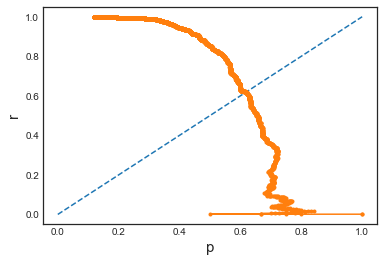

In [70]:
from sklearn.metrics import precision_recall_curve

probs = best.decision_function(X_test)
p,r,t = precision_recall_curve(y_test.ravel(),probs.ravel())
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(p, r, marker='.')
plt.xlabel('p',fontsize='15')
plt.ylabel('r',fontsize='15')
plt.show()


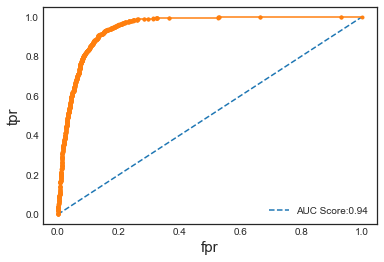

AUC: 0.944


In [73]:
y_pred_prob = best.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
auc_score = roc_auc_score(y_test, y_pred_prob[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('fpr',fontsize='15')
plt.ylabel('tpr',fontsize='15')
plt.legend(["AUC Score:" + "{0:.2f}".format(auc_score)],)
plt.show()

print('AUC: %.3f' % auc_score)
